# Predicting delays in commercial flights - DS Challenge ITA 2024 - 2

## Data

In [1]:
import pandas as pd

public = pd.read_csv('public_f2.csv')
public['hora_ref'] = pd.to_datetime(public['hora_ref'], utc=True)
public.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302399 entries, 0 to 302398
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   flightid                       302399 non-null  object             
 1   dt_dep                         302399 non-null  object             
 2   dt_arr                         302399 non-null  object             
 3   hora_ref                       302399 non-null  datetime64[ns, UTC]
 4   origem                         302399 non-null  object             
 5   destino                        302399 non-null  object             
 6   url_img_satelite               298666 non-null  object             
 7   metaf                          155737 non-null  object             
 8   metar                          300770 non-null  object             
 9   prev_troca_cabeceira           302399 non-null  int64              
 10  troca_ca

### METAR & METAF info

In [2]:
from metpy.io import parse_metar

process_metar = True

if process_metar:
    metar = public.loc[:, ['hora_ref', 'metar']].drop_duplicates()
    
    parsed_metars = []
    for sample in metar.index:
        try:
            res = parse_metar(metar.loc[sample, 'metar'], month=metar.loc[sample, 'hora_ref'].month, year=metar.loc[sample, 'hora_ref'].year)
        except:
            pass
        parsed_metars.append(res)
    
    metar = pd.DataFrame(parsed_metars)
    metar.rename(columns={'skyc1': 'low_cloud_type', 'skylev1': 'low_cloud_level',
                       'skyc2': 'medium_cloud_type', 'skylev2': 'medium_cloud_level',
                       'skyc3': 'high_cloud_type', 'skylev3': 'high_cloud_level',
                       'skyc4': 'highest_cloud_type', 'skylev4': 'highest_cloud_level',
                       'cloudcover': 'cloud_coverage', 'temperature': 'air_temperature',
                       'dewpoint': 'dew_point_temperature'}, inplace=True)
    metar = metar.dropna(subset=['station_id', 'date_time'])
    metar = metar.drop_duplicates(subset=['station_id', 'date_time'])
    metar.to_csv('metar.csv', index=False)

else:
    metar = pd.read_csv('metar.csv', low_memory=False)

metar['date_time'] = pd.to_datetime(metar['date_time'], utc=True)
metar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75024 entries, 0 to 75334
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   station_id             75024 non-null  object             
 1   latitude               75024 non-null  float64            
 2   longitude              75024 non-null  float64            
 3   elevation              75024 non-null  int64              
 4   date_time              75024 non-null  datetime64[ns, UTC]
 5   wind_direction         71156 non-null  float64            
 6   wind_speed             75023 non-null  float64            
 7   wind_gust              580 non-null    float64            
 8   visibility             75020 non-null  float64            
 9   current_wx1            10349 non-null  object             
 10  current_wx2            2020 non-null   object             
 11  current_wx3            10 non-null     object             


In [3]:
from metpy.io import parse_metar

process_metaf = True

if process_metaf:
    # metaf = public.loc[:, ['hora_ref', 'metaf']].drop_duplicates(subset='metaf')
    metaf = public.loc[:, ['hora_ref', 'metaf']].drop_duplicates()
    
    parsed_metafs = []
    for sample in metaf.index:
        data = metaf.loc[sample, 'metaf']
        if isinstance(data, float):
            continue
        data= data.replace('METAF', 'METAR')
        try:
            res = parse_metar(data, month=metaf.loc[sample, 'hora_ref'].month, year=metaf.loc[sample, 'hora_ref'].year)
        except:
            pass
        parsed_metafs.append(res)
    
    metaf = pd.DataFrame(parsed_metafs)
    metaf= metaf.rename(columns={'skyc1': 'low_cloud_type', 'skylev1': 'low_cloud_level',
                       'skyc2': 'medium_cloud_type', 'skylev2': 'medium_cloud_level',
                       'skyc3': 'high_cloud_type', 'skylev3': 'high_cloud_level',
                       'skyc4': 'highest_cloud_type', 'skylev4': 'highest_cloud_level',
                       'cloudcover': 'cloud_coverage', 'temperature': 'air_temperature',
                       'dewpoint': 'dew_point_temperature'})
    metaf = metaf.dropna(subset=['station_id', 'date_time'])
    metaf = metaf.drop_duplicates(subset=['station_id', 'date_time'])
    metaf.to_csv('metaf.csv', index=False)

else:
    metaf = pd.read_csv('metaf.csv', low_memory=False)

metaf['date_time'] = pd.to_datetime(metaf['date_time'], utc=True)
metaf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35170 entries, 0 to 35169
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   station_id             35170 non-null  object             
 1   latitude               35170 non-null  float64            
 2   longitude              35170 non-null  float64            
 3   elevation              35170 non-null  int64              
 4   date_time              35170 non-null  datetime64[ns, UTC]
 5   wind_direction         35170 non-null  int64              
 6   wind_speed             35170 non-null  float64            
 7   wind_gust              0 non-null      float64            
 8   visibility             35170 non-null  int64              
 9   current_wx1            10106 non-null  object             
 10  current_wx2            25 non-null     object             
 11  current_wx3            0 non-null      float64        

In [4]:
# TODO: try with merge_asof
import pandas as pd

process = True

def merge_df_metarf(df1, df2, origem_destino, metar_metaf):
    return pd.merge(left=df1, right=df2.add_suffix(f'_{origem_destino}_{metar_metaf}'), left_on=['hora_ref', origem_destino], right_on=[f'date_time_{origem_destino}_{metar_metaf}',f'station_id_{origem_destino}_{metar_metaf}'], how='left')

if process:
    try:
        df = public.copy()
        df = merge_df_metarf(df, metar, 'origem', 'metar')
        df = merge_df_metarf(df, metar, 'destino', 'metar')
        df = merge_df_metarf(df, metaf, 'origem', 'metaf')
        df = merge_df_metarf(df, metaf, 'destino', 'metaf')
        df.to_csv('processed_public.csv', index=False)
        del public, metar, metaf
    except NameError:
        pass
else:
    df = pd.read_csv('processed_public.csv', low_memory=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302399 entries, 0 to 302398
Columns: 124 entries, flightid to remarks_destino_metaf
dtypes: datetime64[ns, UTC](5), float64(79), int64(2), object(38)
memory usage: 286.1+ MB


<Axes: >

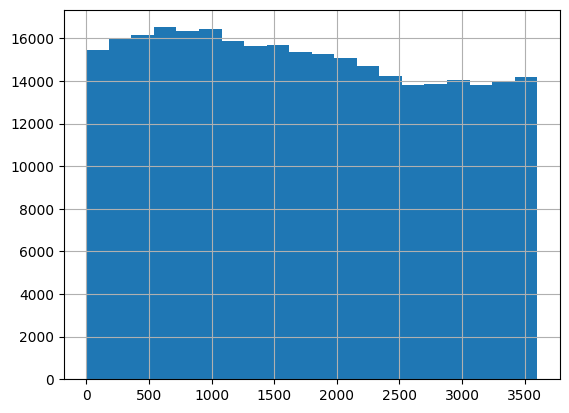

In [36]:
(pd.to_datetime(df['dt_dep']) - df['hora_ref']).dt.seconds.hist(bins=20)